Initial data points: 3275
Data after filtering: 2596
Rows removed: 679

Observed Frequencies:
Successful         0     1
Race_Alignment            
0               1058  1369
1                328   520

Expected Frequencies:
Successful           0        1
Race_Alignment                 
0               731.06  1050.94
1               333.94   480.06
Success Rates by Race Alignment:
Successful             0         1
Race_Alignment                    
0               0.420875  0.579125
1               0.386978  0.613022

Chi-squared p-value: 0.1127
Expected Frequencies:
 [[ 731.05932203 1050.94067797]
 [ 333.94067797  480.05932203]]


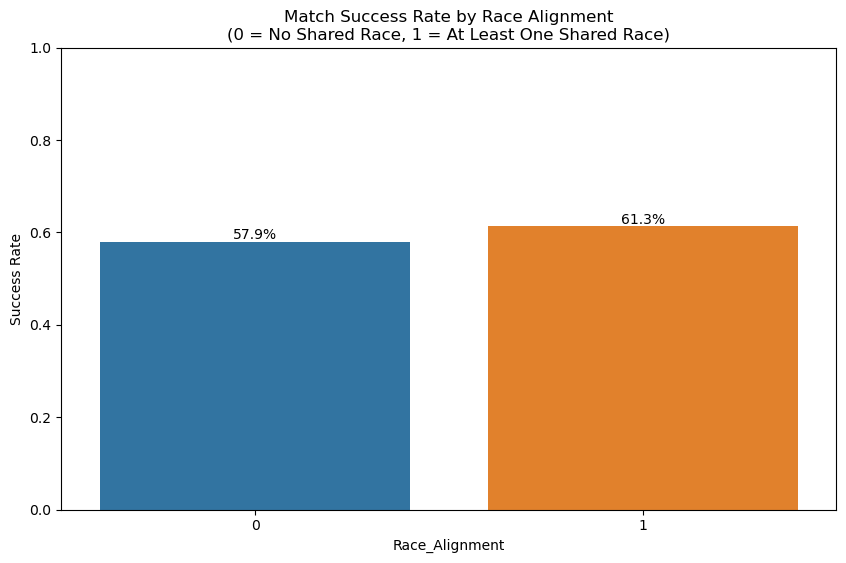

All tests passed!


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# --------------------------------------------------
# STEP 1: Data Preparation
# --------------------------------------------------
# Define standardized race categories
RACE_CATEGORIES = {
    'white': 'White',
    'black': 'Black',
    'hispanic': 'Hispanic',
    'asian': 'Asian',
    'pacific islander': 'Pacific Islander',
    'native american': 'Native American'
}

def standardize_race(race_str):
    """Process race strings with complex cases"""
    if pd.isna(race_str):
        return []
    
    processed = set()
    races = [r.strip().lower() for r in race_str.split(';')]
    
    for race in races:
        base_race = race.split('-')[0].strip()
        
        if 'prefer not to say' in base_race:
            processed.add('Prefer Not To Say')
            continue
            
        if 'other' in base_race:
            if '-' in race and not base_race == 'other':
                main_category = race.split('-')[0].strip()
                if main_category in RACE_CATEGORIES:
                    processed.add(RACE_CATEGORIES[main_category])
            continue
            
        # Explicitly use the global dictionary
        for key, value in RACE_CATEGORIES.items():
            if key in base_race:
                processed.add(value)
                break
        else:
            if base_race:
                processed.add(base_race.title())
    
    return list(processed)

# Apply standardization
df['Big_Race'] = df['Big Race/Ethnicity'].apply(standardize_race)
df['Little_Race'] = df['Little Participant: Race/Ethnicity'].apply(standardize_race)

# --------------------------------------------------
# STEP 2: Filtering
# --------------------------------------------------
# Define exclusion criteria
EXCLUDED_TERMS = ['Prefer not To say', 'Other', '']

# Create filtering mask
valid_mask = (
    ~df['Big_Race'].apply(lambda x: any(r in EXCLUDED_TERMS for r in x)) &
    ~df['Little_Race'].apply(lambda x: any(r in EXCLUDED_TERMS for r in x)) &
    (df['Big_Race'].apply(len) > 0) &  # Parentheses added
    (df['Little_Race'].apply(len) > 0)  # Parentheses added
)

df_filtered = df[valid_mask].copy()

# --------------------------------------------------
# STEP 3: Analysis
# --------------------------------------------------
# Create alignment flag
df_filtered['Race_Alignment'] = df_filtered.apply(
    lambda row: 1 if len(set(row['Big_Race']) & set(row['Little_Race'])) > 0 else 0,
    axis=1
)

# Create success flag
df_filtered['Successful'] = (
    (df_filtered['Stage'] == 'Active') |
    (df_filtered['Closure Reason'].isin(['Child: Graduated', 'Successful Match Closure'])) |
    (df_filtered['Match Length'] > 18)
).astype(int)

# --------------------------------------------------
# STEP 4: Statistical Testing
# --------------------------------------------------
# Create contingency table
contingency_table = pd.crosstab(df_filtered['Race_Alignment'], df_filtered['Successful'])

# Chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# --------------------------------------------------
# STEP 5: Reporting
# --------------------------------------------------
print(f"Initial data points: {len(df)}")
print(f"Data after filtering: {len(df_filtered)}")
print(f"Rows removed: {len(df) - len(df_filtered)}\n")
expected_df = pd.DataFrame(
    expected,
    index=observed.index,
    columns=observed.columns
).round(0).astype(int)  # Round to nearest whole number

print("Observed Frequencies:")
print(observed)
print("\nExpected Frequencies:")
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index,
    columns=contingency_table.columns
).round(2)
print(expected_df)
print("Success Rates by Race Alignment:")
print(pd.crosstab(df_filtered['Race_Alignment'], df_filtered['Successful'], normalize='index'))
print(f"\nChi-squared p-value: {p_value:.4f}")
print("Expected Frequencies:\n", expected)

# --------------------------------------------------
# STEP 6: Visualization
# --------------------------------------------------
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Race_Alignment',
    y='Successful',
    data=df_filtered,
    estimator=lambda x: sum(x)/len(x),
    errorbar=None
)

plt.title('Match Success Rate by Race Alignment\n(0 = No Shared Race, 1 = At Least One Shared Race)')
plt.ylabel('Success Rate')
plt.ylim(0, 1)

# Add percentage labels
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1%}',
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.show()

# Test case: Should categorize "Hispanic - Other" as Hispanic
test_input = "Hispanic - Other"
assert standardize_race(test_input) == ['Hispanic'], "Failed to categorize Hispanic-Other"

# Test case: Should exclude standalone "Other"
test_input = "Other"
assert standardize_race(test_input) == [], "Failed to exclude standalone Other"

# Test case: Should exclude standalone "Other"
test_input = "Hispanic; Other;"
assert standardize_race(test_input) == ['Hispanic'], "Failed to include Other"

print("All tests passed!")

Observed Frequencies:
Successful         0     1
Race_Alignment            
0               1058  1369
1                328   520

Expected Frequencies:
Successful         0     1
Race_Alignment            
0               1027  1400
1                359   489
Total data points: 3275
Unknown matches: 588

Success Rates by Race Alignment:
Successful             0         1
Race_Alignment                    
0               0.435929  0.564071
1               0.386792  0.613208

Chi-squared p-value: 0.0142


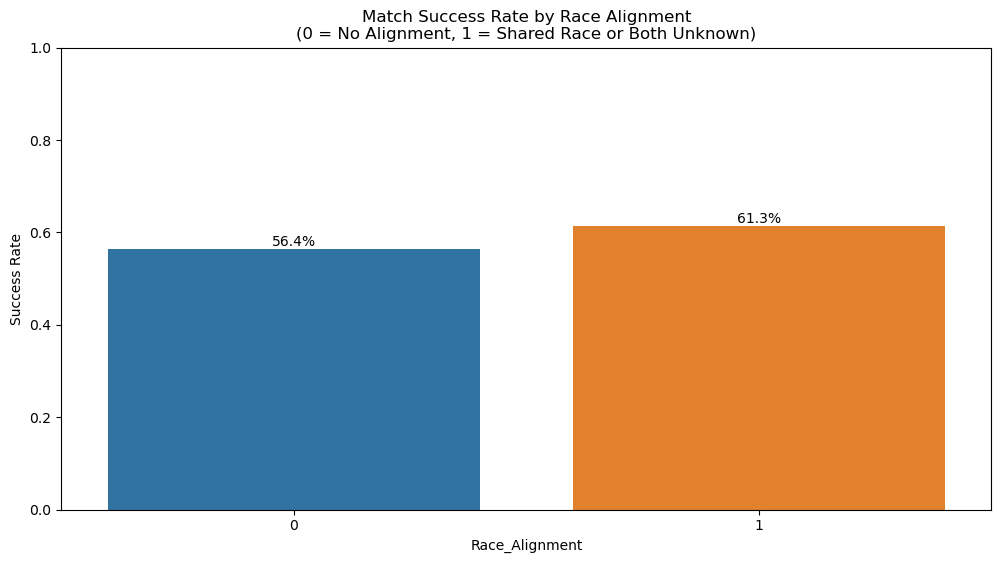

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# --------------------------------------------------
# STEP 1: Data Standardization
# --------------------------------------------------
RACE_CATEGORIES = {
    'white': 'White',
    'black': 'Black',
    'hispanic': 'Hispanic',
    'asian': 'Asian',
    'pacific islander': 'Pacific Islander',
    'native american': 'Native American'
}

def standardize_race(race_str):
    """Process race entries with special handling for unknowns"""
    if pd.isna(race_str):
        return []
    
    processed = set()
    races = [r.strip().lower() for r in race_str.split(';')]
    
    for race in races:
        base_race = race.split('-')[0].strip()
        
        # Handle special cases
        if 'prefer not to say' in base_race or base_race == 'other':
            processed.add('Unknown')
            continue
            
        if 'other' in race and '-' in race:
            main_category = race.split('-')[0].strip()
            if main_category in RACE_CATEGORIES:
                processed.add(RACE_CATEGORIES[main_category])
            continue
            
        # Map base categories
        for key, value in RACE_CATEGORIES.items():
            if key in base_race:
                processed.add(value)
                break
        else:
            if base_race:
                processed.add(base_race.title())
    
    return list(processed)

# Apply standardization
df['Big_Race'] = df['Big Race/Ethnicity'].apply(standardize_race)
df['Little_Race'] = df['Little Participant: Race/Ethnicity'].apply(standardize_race)

# --------------------------------------------------
# STEP 2: Create Unknown Flag
# --------------------------------------------------
df['unknown'] = df.apply(
    lambda row: 1 if (
        'Unknown' in row['Big_Race'] or 
        'Unknown' in row['Little_Race']
    ) else 0,
    axis=1
)

# --------------------------------------------------
# STEP 3: Enhanced Alignment Logic
# --------------------------------------------------
def check_alignment(row):
    big_races = set(row['Big_Race'])
    little_races = set(row['Little_Race'])
    
    # Case 1: Shared known races
    if len(big_races.intersection(little_races)) > 0:
        return 1

    
    # Case 2: Both unknown
    if 'Unknown' in big_races and 'Unknown' in little_races:
        return 1
    
    return 0

df['Race_Alignment'] = df.apply(check_alignment, axis=1)

# --------------------------------------------------
# STEP 4: Success Analysis
# --------------------------------------------------
# Create success flag
df['Successful'] = (
    (df['Stage'] == 'Active') |
    (df['Closure Reason'].isin(['Child: Graduated', 'Successful Match Closure'])) |
    (df['Match Length'] > 18)
).astype(int)

# --------------------------------------------------
# STEP 5: Statistical Analysis
# --------------------------------------------------
contingency_table = pd.crosstab(df['Race_Alignment'], df['Successful'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
observed = pd.crosstab(df['Race_Alignment'], df['Successful'])

# Format expected frequencies
expected_df = pd.DataFrame(
    expected,
    index=observed.index,
    columns=observed.columns
).round(0).astype(int)  # Round to nearest whole number

print("Observed Frequencies:")
print(observed)
print("\nExpected Frequencies (if no association):")
print(expected_df)
print(f"\nChi-squared p-value: {p_value:.4f}")

print(f"Total data points: {len(df)}")
print(f"Unknown matches: {df['unknown'].sum()}")
print("\nSuccess Rates by Race Alignment:")
print(pd.crosstab(df['Race_Alignment'], df['Successful'], normalize='index'))
print(f"\nChi-squared p-value: {p_value:.4f}")
# --------------------------------------------------
# STEP 6: Visualization
# --------------------------------------------------
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Race_Alignment', y='Successful', data=df, errorbar=None)

plt.title('Match Success Rate by Race Alignment\n(0 = No Alignment, 1 = Shared Race or Both Unknown)')
plt.ylabel('Success Rate')
plt.ylim(0, 1)

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()